# Pound-Drever-Hall Locking

In order to maintain the resonance condition, optical resonators are often locked. Optical resonators do not always need to be locked in FINESSE, as the mirrors can be places at the operating point exactly. However, some effects such as beam shape distortions drag the operating point of the resonator, and in these instances it is valuable to simulate the locking loop.

In this example, a two mirror cavity will be locked using a simple lopp, using the Pound-Drever-Hall technique [[11](https://doi.org/10.1007/BF00702605)]. We will move the end mirror and watch the simulation adjust the position of the input mirror to maintain the operating point.

## The Optical Setup

The optical setip and kat code are shown below:

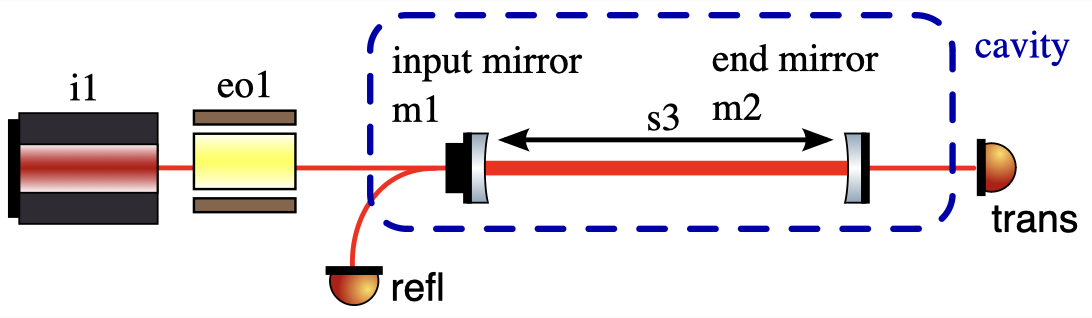

In [1]:
import finesse

finesse.configure(plotting=True)

model = finesse.Model()
model.parse(
    """
    laser i1 P=1 f=0
    space s1 portA=i1.p1 portB=eo1.p1
    modulator eo1 15M 0.7 order=3
    space s2 portA=eo1.p2 portB=m1.p1
    mirror m1 R=0.9 T=0.1
    space s3 portA=m1.p2 portB=m2.p1 L=1
    mirror m2 R=0.9 T=0.1

    power_detector_dc refl node=m1.p1.o
    power_detector_dc trans node=m2.p2.o
    """
)

## Optimising the Demodulation Phase

We can then create a number of power detectors with different demodulation phases and inspect to see which one is optimal

In [2]:
import numpy as np

for phase in np.linspace(0, 90, endpoint=True, num=6):
    model.parse(f"pd1 pdh{phase:.0f} node=m1.p1.o f=eo1.f phase={phase:.0f}")

The demodulation frequency of the photodiode is linked to the modulation frequency of the electro-optic modulator using a reference. As you can see below, if we scan the cavity we see error signal cross zero at the operating point. We also see the resonance peaks for the sidebands created by the EOM.

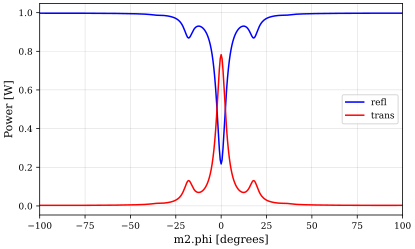

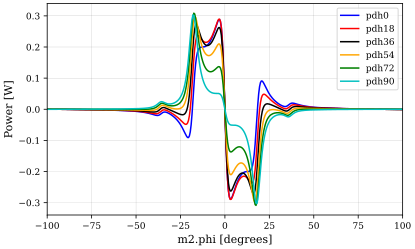

In [3]:
model.parse("xaxis(m2.phi, lin, -100, 100, 400)")
model.run().plot();

We can see that a demodulation phase of 18 degrees produces a reasonable error signal. 

If required, we can compute the error signal by producing many detectors at different phases and computing the gradient of the error signal, as shown below.

Removed pdh0
Removed pdh18
Removed pdh36
Removed pdh54
Removed pdh72
Removed pdh90
Maximum error signal gradient occurs at 9 degrees


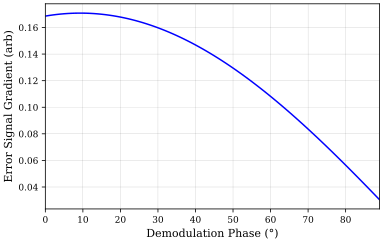

In [4]:
def remove_demod_pds(verbose=True):
    for el in model.elements:
        if el.startswith('pdh'):
            model.remove(el)
            if verbose: print(f'Removed {el}')

# Remove the old detectors.
remove_demod_pds()

# Create another array of phases.
phases = np.arange(0,90,1)
for phase in phases:
    model.parse(f"pd1 pdh{phase:.0f} node=m1.p1.o f=eo1.f phase={phase:.0f}")

# Sweep the mirror tuning across 3 points: ±1° and 0.
model.parse("xaxis(m2.phi, lin, -1, 1, 2)")
out = model.run()

# Calculate the gradient of the error signal.
grad = []
for phase in phases:
    var = out[f'pdh{phase}']
    grad.append((var[0] - var[-1])/2)

# Find the maximum gradient.
grad = np.array(grad)
idxmax = np.argmax(np.abs(grad))
print(f'Maximum error signal gradient occurs at {phases[idxmax]} degrees')

# Plot.
from matplotlib import pyplot as plt
plt.plot(phases,grad)
plt.xlabel('Demodulation Phase (°)')
plt.ylabel('Error Signal Gradient (arb)');

## Closing the Loop

The cavity can then be locked to the operating point using the **lock** command. The simulation must be instructed to run the locks before each step, otherwise it will not do this.

> Note: The lock command only accepts real inputs and therefore you must specify a demodulation phase for the power detector, so that it outputs real numbers, if you wish to use it in a locking loop.

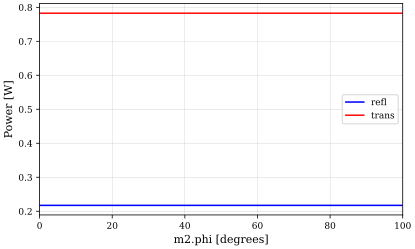

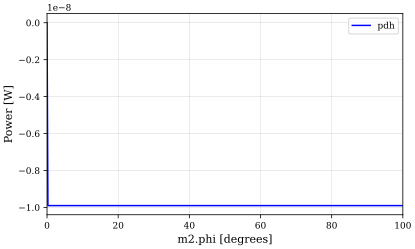

In [5]:
remove_demod_pds(verbose=False)
model.parse("""
power_detector_demod_1 pdh node=m1.p1.o f=eo1.f phase=9
lock lock_length pdh m1.phi -10 1e-8
xaxis(m2.phi, lin, 0, 100, 400, pre_step=run_locks())
""")
model.run().plot();

As you can see, the position of M1 is now controlled to maintain the cavity resonance.

## Using complex power demodulation for demodulation phase calculation

The optimal demodulation phase can be computed in multiple ways. As above we can do this manually. Another alternative is to use the power detector with its demodulation phase set to **None**. In this case, the detector outputs the complex-value of the optical beat and a local oscillator before a demodulation phase is applied. The real and imaginary parts of this output are the in-phase and quadrature signals of the error signal. By computing the gradient of the real and imaginary part of this output with respect to the cavity length change we can calculate what the optimal demodulation phase is in much fewer steps.

Here we build the same cavity model as before but with the complex-valued power demodulator.

In [6]:
import finesse
import numpy as np
finesse.init_plotting()

model = finesse.Model()
model.parse(
    """
    laser i1 P=1 f=0
    space s1 portA=i1.p1 portB=eo1.p1
    modulator eo1 15M 0.7 order=3
    space s2 portA=eo1.p2 portB=m1.p1
    mirror m1 R=0.9 T=0.1
    space s3 portA=m1.p2 portB=m2.p1 L=1
    mirror m2 R=0.9 T=0.1

    pd1 pdh_complex m1.p1.o f=eo1.f
    """
)

Next we use the **np.gradient** to perform a finite central difference calculation of the gradient. This requires computing two steps either side of our initial state, we do this with a single step **xaxis**. The optimal demodulation phase is then the complex argument of the differentiated value.

In [7]:
eps = 1e-9 # finite difference step size for gradient calculation
model.parse(f"xaxis(m1.phi, lin, -{eps/2}, {eps/2}, 1, relative=True)")
sol = model.run()
# compute the real and imaginary gradient with respect to the
# cavity length change, then compute the complex argument (angle)
# to get the optimial demodulation phase
opt_demod = np.angle(
    np.gradient(
        sol['pdh_complex'], eps
    ).mean(), # take mean as we need
    deg=True # make sure we compute angle in degrees
)
print(opt_demod)

9.232551216511592


Lastly, we make two real-valued demodulated power detectors for the in-phase and quadrature signals and plot the error signal.

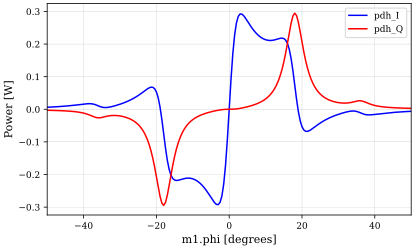

In [8]:
model.parse(f"""
pd1 pdh_I m1.p1.o f=eo1.f phase={opt_demod}
pd1 pdh_Q m1.p1.o f=eo1.f phase={opt_demod+90}
xaxis(m1.phi, lin, -50, 50, 200)
""")
sol = model.run()
sol.plot('pdh_I', 'pdh_Q');